In [1]:
import pickle
import numpy as np
import pandas as pd
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 140)

tweets_text = pd.read_csv("final_dataset_improved.txt", sep='\t', header=None)
tweets_text.columns = ['Text','Label']

print("Out of {} rows, {} are spams, {} are non-spams".format(len(tweets_text),
                                                              len(tweets_text[tweets_text['Label']=='Spam']),
                                                              len(tweets_text[tweets_text['Label']=='Ham'])))

Out of 3994608 rows, 1725268 are spams, 2269340 are non-spams


In [3]:
tweets_text.isnull().sum()

Text     0
Label    0
dtype: int64

In [4]:
# Convert labels to numeric format
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [5]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [6]:
print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 3914714 (98%)
Test data: 39947 (1%)
Validation data: 39947 (1%)


# Start of Word2Vec

In [7]:
# Only for training word2vec model
tweets_text["Tokenized_Text"] = tweets_text["Text"].str.split(" ")
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)
tweets_text.head()

,Text,Label,Tokenized_Text
0,house party daybreak weird fear,0,"[house, party, daybreak, weird, fear]"
1,taxi salt lake city international url,0,"[taxi, salt, lake, city, international, url]"
2,almost home international url,0,"[almost, home, international, url]"
3,lunch url,0,"[lunch, url]"
4,book usermention url,0,"[book, usermention, url]"


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [9]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 3914714 (98%)
Test data: 39947 (1%)
Validation data: 39947 (1%)


In [10]:
def word2vec_embed(train_data, dim=50):
    # Train a basic word2vec model
    w2v_model = gensim.models.Word2Vec(train_data, size=dim, window=5, min_count=1, seed=14) #cbow
    #w2v_model = gensim.models.Word2Vec(train_data, size=dim, sg=1, window=10, min_count=1, seed=14) #skipgram
    #generate a list of words the word2vec model learned work vectors for, words that fulfill min_count condition
    print("Number of words learned: {}".format(len(w2v_model.wv.index2word)))
    print("List of words are: ", w2v_model.wv.index2word)
    
    return w2v_model

In [14]:
w2v_model = word2vec_embed(X_train)

# Save trained cbow word2vec model
with open('w2v_cbow_model.pickle', 'wb') as saved_model:
    pickle.dump(w2v_model, saved_model, protocol=pickle.HIGHEST_PROTOCOL)

Number of words learned: 27
List of words are:  [' ', 'e', 'r', 't', 'n', 'o', 'a', 'i', 'l', 's', 'u', 'm', 'c', 'd', 'h', 'p', 'w', 'g', 'y', 'k', 'b', 'f', 'v', 'x', 'j', 'z', 'q']


In [11]:
# Load trained cbow word2vec model
with open('w2v_cbow_model.pickle', 'rb') as saved_model:
    w2v_model = pickle.load(saved_model)

In [17]:
w2v_model = word2vec_embed(X_train)

# Save trained skipgram word2vec model
with open('w2v_skipgram_model.pickle', 'wb') as saved_model:
    pickle.dump(w2v_model, saved_model, protocol=pickle.HIGHEST_PROTOCOL)

Number of words learned: 27
List of words are:  [' ', 'e', 'r', 't', 'n', 'o', 'a', 'i', 'l', 's', 'u', 'm', 'c', 'd', 'h', 'p', 'w', 'g', 'y', 'k', 'b', 'f', 'v', 'x', 'j', 'z', 'q']


In [ ]:
# Load trained skipgram word2vec model
with open('w2v_skipgram_model.pickle', 'rb') as saved_model:
    w2v_model = pickle.load(saved_model)

In [12]:
w2v_weights = w2v_model.wv.syn0
print(w2v_weights.shape)

(27, 50)


c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [13]:
w2v_weights[8]

array([-1.020116  , -1.7140335 , -0.34890333,  1.5308877 , -0.0322356 ,
       -0.915195  , -0.25483426,  0.33837557,  0.36784062,  0.7800547 ,
        0.976907  ,  0.45930418, -0.19160323,  0.03732916,  0.7459661 ,
       -0.386383  , -1.1901929 ,  0.11499223, -0.31592575,  2.1030946 ,
       -0.07645109, -0.0282452 ,  0.8153499 ,  0.9303253 , -0.6606414 ,
        0.26896846, -1.1795031 ,  1.4490769 , -0.7367221 ,  0.58247226,
        0.4557023 ,  0.48121658, -0.7404762 ,  0.5412519 , -1.2708431 ,
       -1.4338578 , -0.07910842, -0.6476093 ,  0.05594535, -1.4513528 ,
        1.4465677 , -1.6042846 , -0.48797247, -0.16475275,  1.2230799 ,
        0.6228962 , -0.30257222,  0.56159633,  0.64584374, -0.46983498],
      dtype=float32)

In [23]:
# Train the tokenizer and use that tokenizer to convert sentences into sequences of numbers
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)
print("Number of vocabulary: {}".format(len(tokenizer.word_index)))
print(tokenizer.word_index)

Number of vocabulary: 41762
{'usermention': 1, 'url': 2, 'retweet': 3, 'get': 4, 'new': 5, 'make': 6, 'like': 7, 'love': 8, 'good': 9, 'time': 10, 'day': 11, 'know': 12, 'one': 13, 'think': 14, 'twitter': 15, 'see': 16, 'say': 17, 'free': 18, 'work': 19, 'look': 20, 'want': 21, 'need': 22, 'thank': 23, 'today': 24, 'come': 25, 'take': 26, 'post': 27, 'great': 28, 'video': 29, 'back': 30, 'use': 31, 'watch': 32, 'home': 33, 'follow': 34, 'people': 35, 'best': 36, 'market': 37, 'live': 38, 'news': 39, 'check': 40, 'really': 41, 'find': 42, 'right': 43, 'show': 44, 'money': 45, 'game': 46, 'way': 47, 'would': 48, 'life': 49, 'feel': 50, 'well': 51, 'man': 52, 'still': 53, 'try': 54, 'start': 55, 'help': 56, 'night': 57, 'much': 58, 'tweet': 59, 'world': 60, 'business': 61, 'let': 62, 'give': 63, 'last': 64, 'play': 65, 'first': 66, 'please': 67, 'call': 68, 'wait': 69, 'happy': 70, 'via': 71, 'tell': 72, 'better': 73, 'job': 74, 'week': 75, 'even': 76, 'year': 77, 'never': 78, 'read': 79,

In [24]:
with open('tokenizer_improved_noOOV.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
#Load the tokenizer
with open('tokenizer_improved_noOOV.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

print("Number of vocabulary: {}".format(len(tokenizer.word_index)))

Number of vocabulary: 41762


# End of Word2Vec

In [15]:
def text_processing(data, maxlen):
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    return seq_pad

In [16]:
X_train_seq_padded = text_processing(X_train,20)
X_test_seq_padded = text_processing(X_test,20)
X_val_seq_padded = text_processing(X_val,20)

In [15]:
def model_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(LSTM(32, dropout=0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [33]:
def model_bilstm():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [28]:
def model_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=len(w2v_model.wv.index2word), output_dim=50, input_length=max_len, 
                        weights=[w2v_weights], trainable=False))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model   

# Implement Transformer 

In [28]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [34]:
vocab_size=len(tokenizer.word_index)+1
maxlen=20
print(vocab_size)

41763


In [30]:
def model_transformer():    
    embed_dim = 50  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
def plot_graphs(history, metrics, title, epochs):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.xticks(range(0,epochs))
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

In [17]:
max_len = 20
model = model_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            2088150   
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,099,863
Trainable params: 2,099,863
Non-trainable params: 0
_________________________________________________________________


In [31]:
tf.keras.utils.plot_model(model, "lstm_word2vec.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [36]:
# Compile the model
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks list
#filepath = 'tranformer_word2vec.hdf5'
#filepath = 'cnn_word2vec.hdf5'
filepath = 'bilstm_word2vec.hdf5'

callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 512
epochs = 2

with tf.device('/device:GPU:3'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_seq_padded, y_val), verbose=1, callbacks=callbacks_list)

Epoch 1/2
7646/7646 [==============================] - ETA: 0s - loss: 3.4544e-04 - accuracy: 0.9999
Epoch 1: val_loss improved from inf to 0.00000, saving model to bilstm_word2vec.hdf5
7646/7646 [==============================] - 1642s 212ms/step - loss: 3.4544e-04 - accuracy: 0.9999 - val_loss: 4.7972e-06 - val_accuracy: 1.0000
Epoch 2/2
7646/7646 [==============================] - ETA: 0s - loss: 7.1901e-06 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to bilstm_word2vec.hdf5
7646/7646 [==============================] - 1860s 243ms/step - loss: 7.1901e-06 - accuracy: 1.0000 - val_loss: 1.3221e-07 - val_accuracy: 1.0000


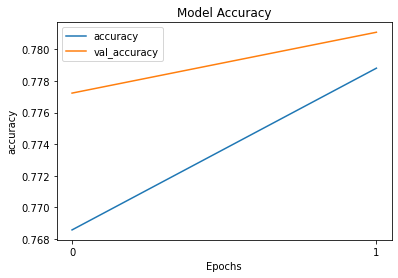

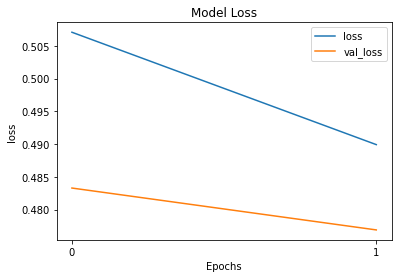

In [21]:
plot_graphs(history, 'accuracy', 'Model Accuracy',2)
plot_graphs(history, 'loss', 'Model Loss',2)

In [22]:
model = load_model('lstm_word2vec.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 365s 45ms/step - loss: 0.4686 - accuracy: 0.7877
Train Accuracy: 0.788
Train Loss: 0.469


In [24]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 184s 5ms/step - loss: 0.4769 - accuracy: 0.7811
Validation Accuracy: 0.781
Validation Loss: 0.477


In [25]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 160s 4ms/step - loss: 0.4792 - accuracy: 0.7808
Test Accuracy: 0.781
Test Loss: 0.479


In [26]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 10s 5ms/step
Accuracy: 0.781
Precision: 0.787
Recall: 0.678
F-Measure: 0.728


In [27]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     22629
           1       0.79      0.68      0.73     17318

    accuracy                           0.78     39947
   macro avg       0.78      0.77      0.77     39947
weighted avg       0.78      0.78      0.78     39947



Text(0.5, 1.0, 'Confusion Matrix')

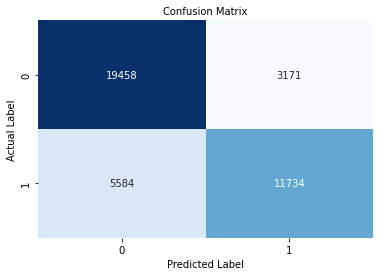

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [29]:
X_test.head()

2354087             top fashion trend summer url
3313731                             save use url
3975146                         keyboard nut win
981380                   cant wait get new album
2590449    coach train click click step step url
Name: Text, dtype: object

In [30]:
y_pred[0:5]

array([[1],
       [1],
       [0],
       [0],
       [1]])

In [31]:
y_test[0:5]

array([1, 1, 1, 0, 1])

In [32]:
df_list = list(X_test.values)
df = pd.DataFrame(df_list, columns=["text"])
df["actual"] = y_test
df["predicted"] = y_pred

incorrect = df[df["actual"] != df["predicted"]]

In [33]:
incorrect

,text,actual,predicted
2,keyboard nut win,1,0
14,short sweet tip design web article quickly run url,0,1
25,new plan add top customer rat new floor plan add url,0,1
28,retweet usermention usermention thank mention hey fellow check person great weekend,0,1
30,better late never nightmare vault comment get leave url,0,1
...,...,...,...
39918,phone die suck,1,0
39921,subscribe channel url,0,1
39928,usermention way make menace,1,0
39930,die die url,1,0


In [34]:
#export incorrect
incorrect.to_csv('incorrect_lstm_word2vec.txt', sep='\t', index=False, header=False)

In [35]:
df_list = list(X_test.values)
df1 = pd.DataFrame(df_list, columns=["text"])
df1["actual"] = y_test
df1["predicted"] = y_pred

correct = df1[df1["actual"] == df1["predicted"]]

In [36]:
correct

,text,actual,predicted
0,top fashion trend summer url,1,1
1,save use url,1,1
3,cant wait get new album,0,0
4,coach train click click step step url,1,1
5,yes dose,0,0
...,...,...,...
39942,ana ser url,0,0
39943,usermention backup,0,0
39944,photo colour photograph url,0,0
39945,retweet usermention head strip club cant find bag nickel,0,0


In [37]:
#export correct
correct.to_csv('correct_lstm_word2vec.txt', sep='\t', index=False, header=False)

# Start of CNN Model

In [30]:
max_len = 20
model = model_cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            1350      
                                                                 
 conv1d (Conv1D)             (None, 18, 256)           38656     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)               

In [18]:
model = load_model('cnn_word2vec.hdf5', compile=False)
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Define callbacks list
filepath = 'cnn_word2vec.hdf5'
callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 512
epochs = 2

with tf.device('/device:GPU:3'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_seq_padded, y_val), verbose=1, callbacks=callbacks_list)

Epoch 1/2
7646/7646 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.7605
Epoch 1: val_loss improved from inf to 0.48603, saving model to cnn_word2vec.hdf5
7646/7646 [==============================] - 1057s 137ms/step - loss: 0.5195 - accuracy: 0.7605 - val_loss: 0.4860 - val_accuracy: 0.7760
Epoch 2/2
7646/7646 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.7760
Epoch 2: val_loss improved from 0.48603 to 0.47845, saving model to cnn_word2vec.hdf5
7646/7646 [==============================] - 1278s 167ms/step - loss: 0.4955 - accuracy: 0.7760 - val_loss: 0.4784 - val_accuracy: 0.7800


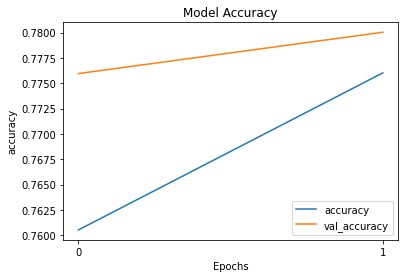

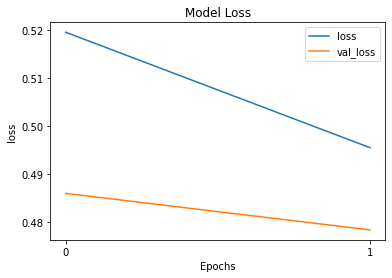

In [21]:
plot_graphs(history, 'accuracy', 'Model Accuracy',2)
plot_graphs(history, 'loss', 'Model Loss',2)

In [22]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 295s 39ms/step - loss: 0.4730 - accuracy: 0.7850
Train Accuracy: 0.785
Train Loss: 0.473


In [23]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 210s 5ms/step - loss: 0.4784 - accuracy: 0.7800
Validation Accuracy: 0.78
Validation Loss: 0.478


In [24]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 284s 7ms/step - loss: 0.4801 - accuracy: 0.7800
Test Accuracy: 0.78
Test Loss: 0.48


In [25]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 13s 7ms/step
Accuracy: 0.78
Precision: 0.786
Recall: 0.677
F-Measure: 0.727


In [26]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     22629
           1       0.79      0.68      0.73     17318

    accuracy                           0.78     39947
   macro avg       0.78      0.77      0.77     39947
weighted avg       0.78      0.78      0.78     39947



Text(0.5, 1.0, 'Confusion Matrix')

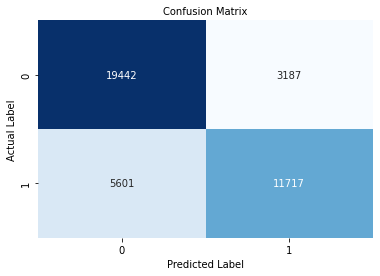

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

# End of CNN Model

# Start of Transformer Model

In [32]:
max_len = 20
model = model_transformer()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           2089150   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 20, 50)           23832     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

# Start of Bi-LSTM Model

In [35]:
max_len = 20
model = model_bilstm()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 50)            2088150   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,151,191
Trainable params: 2,151,191
Non-trainable params: 0
____________________________________________

In [37]:
model = load_model('bilstm_word2vec.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

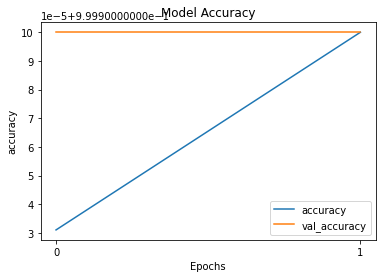

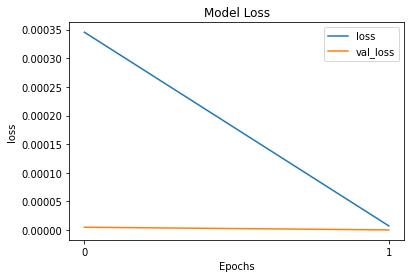

In [38]:
plot_graphs(history, 'accuracy', 'Model Accuracy',2)
plot_graphs(history, 'loss', 'Model Loss',2)

In [40]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 1629s 206ms/step - loss: 0.4870 - accuracy: 0.8251
Train Accuracy: 0.825
Train Loss: 0.487


In [41]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 594s 15ms/step - loss: 0.4882 - accuracy: 0.8253
Validation Accuracy: 0.825
Validation Loss: 0.488


In [42]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 486s 12ms/step - loss: 0.4890 - accuracy: 0.8243
Test Accuracy: 0.824
Test Loss: 0.489


In [43]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 14s 10ms/step
Accuracy: 0.824
Precision: 0.0
Recall: 0.0
F-Measure: 0.0


c:\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     39947
           1       0.00      0.00      0.00         0

    accuracy                           0.82     39947
   macro avg       0.50      0.41      0.45     39947
weighted avg       1.00      0.82      0.90     39947



c:\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

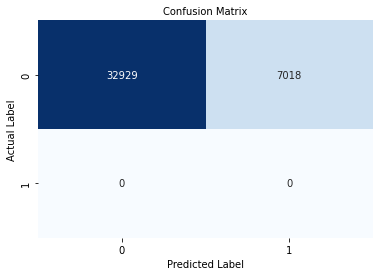

In [45]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)